# Hello, 
This notebook is how my project goes. 
this project is called loan prediction using random forest classifier

### This project is using an open dataset from Kaggle
link : https://www.kaggle.com/datasets/kmldas/loan-default-prediction

This is a synthetic dataset created using actual data from a financial institution. The data has been modified to remove identifiable features and the numbers transformed to ensure they do not link to original source (financial institution). This is intended to be used for academic purposes for beginners who want to practice financial analytics from a simple financial dataset


In [2]:
# import common package
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler

import warnings 
warnings.filterwarnings('ignore')

In [4]:
#import data
df = pd.read_csv('Default_Fin.csv', index_col='Index')
df.head()

,Employed,Bank Balance,Annual Salary,Defaulted?
Index,,,,
1,1,8754.36,532339.56,0
2,0,9806.16,145273.56,0
3,1,12882.60,381205.68,0
4,1,6351.00,428453.88,0
5,1,9427.92,461562.00,0


# First
### we do some simple EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Employed       10000 non-null  int64  
 1   Bank Balance   10000 non-null  float64
 2   Annual Salary  10000 non-null  float64
 3   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 390.6 KB


In [7]:
df.shape
# we can see the data has 10.000 records and 4 column

(10000, 4)

## Also we can use some interesting python package to do automated EDA
Pandas profiling is a Python library that performs an automated Exploratory Data Analysis. It automatically generates a dataset profile report that gives valuable insights. 

In [8]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()

# we can see the dataset does not have missing value 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Create Model

### First stage, we can create simple model

In [9]:
X = df.drop(columns="Defaulted?")
y = df['Defaulted?'] # this is the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 3), (2000, 3), (8000,), (2000,))

In [10]:
## Create Pipeline for Imputer and Transformation

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])


preprocessor = ColumnTransformer([
    ('numeric', numerical_pipe, ['Bank Balance', 'Annual Salary']),
    ('categoric', categorical_pipe, ["Employed"])
])

In [11]:
# we can use Logistic Regression
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

In [12]:
from sklearn.model_selection import GridSearchCV

param = {'algo__fit_intercept': [True, False],
         'algo__C': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]
        }

model = GridSearchCV(pipeline, param, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 1.0, 'algo__fit_intercept': True}
0.9735 0.9733749991678646 0.973


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1933
           1       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



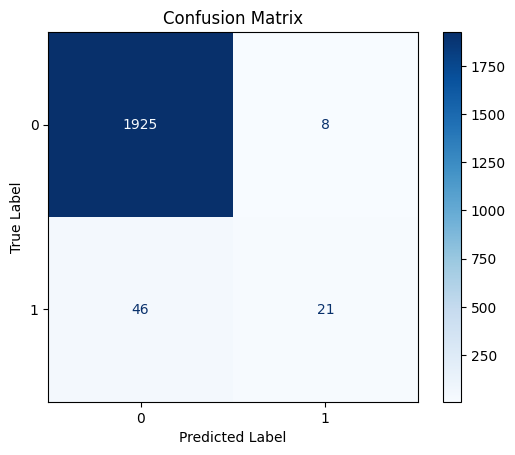

In [14]:
# Doing evaluation
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
import matplotlib.pyplot as plt 

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

color = 'black'
matrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

## So,
we can see the Score is really high (97%) but in this case, that score doesn't really matter.
we must see the f-1 score. F-1 score is really good for predicting 0, why is this happen? this is because imbalance data in target column. So, our model have tendency predict 0 than 1 because it finds 0 more often than 1 when studying the data.

### Then what should we do?
we can do Sampling, for example over sampling with SMOTE 

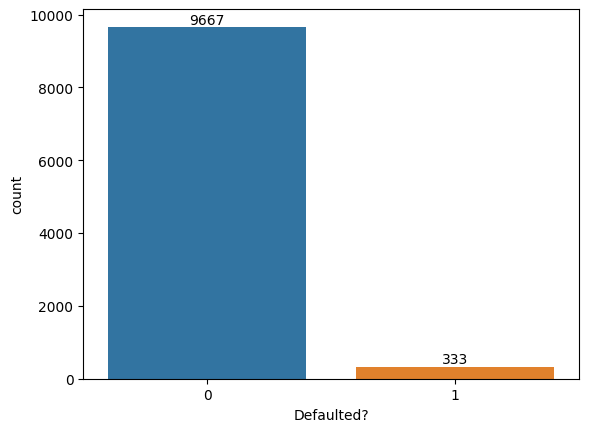

In [15]:
# first check imbalance data
ax = sns.countplot(x='Defaulted?',
                 data=df)

for i in ax.containers:
    ax.bar_label(i,)

In [16]:
# import library for smote
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

0    9667
1    9667
Name: Defaulted?, dtype: int64

In [17]:
## train test split again 
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.25, stratify=y_sm, random_state=42)
X_train_sm.shape, X_test_sm.shape, y_train_sm.shape, y_test_sm.shape

((14500, 3), (4834, 3), (14500,), (4834,))

In [19]:
pipeline_sm = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

param = {'algo__fit_intercept': [True, False],
         'algo__C': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]
        }

model_sm = GridSearchCV(pipeline_sm, param, cv=3, n_jobs=-1, verbose=1)
model_sm.fit(X_train_sm, y_train_sm)

print(model_sm.best_params_)
print(model_sm.score(X_train_sm, y_train_sm), model_sm.best_score_, model_sm.score(X_test_sm, y_test_sm))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 0.01, 'algo__fit_intercept': False}
0.8984827586206896 0.8984139348146162 0.8953247827885809


              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2417
           1       0.87      0.92      0.90      2417

    accuracy                           0.90      4834
   macro avg       0.90      0.90      0.90      4834
weighted avg       0.90      0.90      0.90      4834



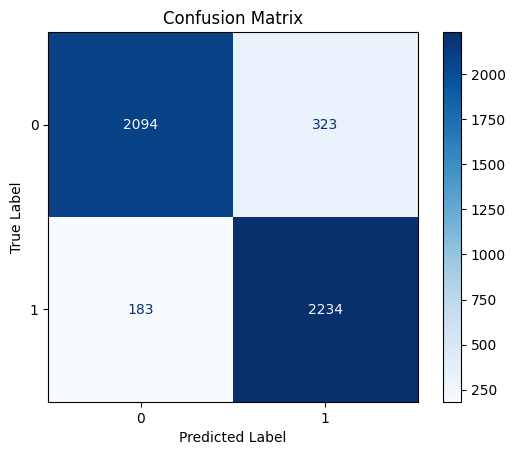

In [22]:
y_pred_sm = model_sm.predict(X_test_sm)

print(classification_report(y_test_sm,y_pred_sm))

color = 'black'
matrix = plot_confusion_matrix(model_sm, X_test_sm, y_test_sm, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

## The prediction is getting better
we can see the f1 score is getting better, what about we using another algorithm

## Then what next? maybe we can change the algorithm to the Random Forest Classifier
Random Forest is strong learner, perhaps we can get a better result.
Strong learner is such a good things but we must concern that random forest could get overfit, so we must set the parameter to handle overfitting tendency

In [23]:
from sklearn.ensemble import RandomForestClassifier
param_rf ={'algo__n_estimators': [100, 150, 200],
             'algo__max_depth': [20, 50, 80],
             'algo__max_features': [0.3, 0.6, 0.8],
             'algo__min_samples_leaf': [1, 5, 10]
}

pipeline_sm_rf = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])


model_sm_rf = GridSearchCV(pipeline_sm_rf, param_rf, cv=3, n_jobs=-1, verbose=1)
model_sm_rf.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['Bank '
                                                                          'Balance',
                                                                          'Annual '
                                                                          'Salary']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Employed'])])),
                                       ('algo',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'algo__max_depth': [20, 50, 80],
                         'algo__max_features': [0.3, 0.6, 0.8],
                         'algo__min_samples_leaf': [1, 5, 10],
                         'algo__n_estimators': [100, 150, 200]},
             verbose=1)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2417
           1       0.91      0.96      0.93      2417

    accuracy                           0.93      4834
   macro avg       0.93      0.93      0.93      4834
weighted avg       0.93      0.93      0.93      4834



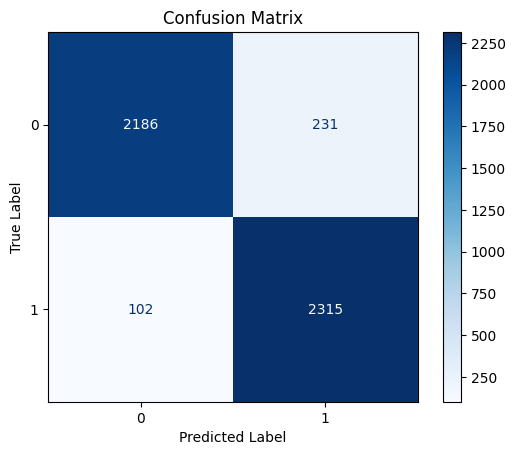

In [24]:
y_pred_sm = model_sm_rf.predict(X_test_sm)

print(classification_report(y_test_sm,y_pred_sm))

color = 'black'
matrix = plot_confusion_matrix(model_sm_rf, X_test_sm, y_test_sm, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

#### As we can see, the model improved based on f1 score. So, we use this algorithm for now

## Last Step
# Save the model

In [25]:
import pickle 

# save the model to disk
filename = 'model_smote_rf.sav'
pickle.dump(model_sm, open(filename, 'wb'))

# Build Simple Website with Streamlit
Next, we build simple website to implement our algorithm with Streamlit Package
File name : app.py